 # Automated Image Classification using Advanced Deep Learning Models

 Group number 2: Renee DeMaio

 The goal for this Lab is it to provide you understanding of the various deep learning models that we will be using in your project(s). In this Lab we will implement VGG Architecture over CUB200-2011 dataset:

 The CUB200-2011 dataset can be found on its [website](https://paperswithcode.com/dataset/cub-200-2011). We can either use the data zip file or import it using  [Kaggle](https://www.kaggle.com) and [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`. I would prefer all of you do this using Google Colab. This will also help you with Last 3 Labs.

  ## Data Preprocessing
 ### Downloading and extracting custom datasets
 ### Loading custom datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries and Set Random Seed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 1), "GB")
    print("Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 1), "GB")

Using device: cuda
NVIDIA L4
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


In [3]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(7598)

In [4]:
# Set Data folders, TensorDatasets and DataLoaders for the datasets

import os
import shutil
from tqdm import tqdm

source_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled"
train_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/train"
test_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/test"
val_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/val"
output_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/output_images"


 ### Calculating the mean and std for normalization on custom datasets


Commented this out because it takes two hours to run on colab. Results are in the transformations below.

In [ ]:
# from pathlib import Path
# import cv2
# import numpy as np
# from tqdm import tqdm

# train_dir = Path(r'/content/drive/MyDrive/DSAN_6500/lab_7to9/cub2002011_dataset/train')
# files = list(train_dir.rglob('*.png'))

# mean = np.array([0., 0., 0.])
# stdTemp = np.array([0., 0., 0.])
# std = np.array([0., 0., 0.])

# numSamples = len(files)

# for i in range(numSamples):
#     im = cv2.imread(str(files[i]))
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = im.astype(float) / 255.

#     for j in range(3):
#         mean[j] += np.mean(im[:, :, j])

# mean = (mean / numSamples)

# for i in range(numSamples):
#     im = cv2.imread(str(files[i]))
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = im.astype(float) / 255.
#     for j in range(3):
#         stdTemp[j] += ((im[:, :, j] - mean[j]) ** 2).sum() / (im.shape[0] * im.shape[1])

# std = np.sqrt(stdTemp / numSamples)

# print(f"Calculated Mean: {mean}")
# print(f"Calculated Standard Deviation: {std}")

### Loading transforms to augment and normalize our data

In [5]:
from PIL import Image

batch_size = 64
numworkers = 2

# the below function tranforms and normalises the data

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.48801502, 0.50715263, 0.43608612], [0.23610121, 0.23127311, 0.27457839])
])

train_dataset = datasets.ImageFolder(train_dir, transform = transform)
test_dataset = datasets.ImageFolder(test_dir, transform = transform)
validation_dataset = datasets.ImageFolder(val_dir, transform = transform)

train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = numworkers)

test_loader = DataLoader(test_dataset,
                          batch_size = batch_size,
                          shuffle = False,
                          num_workers = numworkers)

validation_loader = DataLoader(validation_dataset,
                          batch_size = batch_size,
                          shuffle = False,
                          num_workers = numworkers)

  ## Defining a Convolutional Neural Network
 ### Defining the VGG blocks
 ### Defining a CUB200-2011 VGG model

In [7]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc = "Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss

In [8]:
def compute_metrics(labels, predictions, probs):
    metrics = {
        "Accuracy" : accuracy_score(labels, predictions),
        "Top-5 Accuracy" : top_k_accuracy_score(labels, probs, k = 5),
        "Macro Precision" : precision_score(labels, predictions, average = "macro"),
        "Weighted Precision" : precision_score(labels, predictions, average = "weighted"),
        "Macro Recall" : recall_score(labels, predictions, average = "macro"),
        "Weighted Recall" : recall_score(labels, predictions, average = "weighted"),
        "Weighted F1-Score" : f1_score(labels, predictions, average = "weighted"),
        # "Weighted AUC Score" : roc_auc_score(labels, probs, multi_class = "ovr", average = "weighted"),
        # "Weighted Mean Average Precision" : average_precision_score(labels, probs, average = "weighted")
    }

    return metrics

In [9]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc = "Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(nn.Softmax(dim = 1)(outputs).cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total

    metrics = compute_metrics(all_labels, all_predictions, all_probs)

    return epoch_loss, accuracy, metrics

In [10]:
from typing import Any

class EarlyStopping:
    def __init__(self, patience = 5, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.best_loss is not None:
                print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model ...")
            else:
                print(f"Saving model with validation loss {val_loss:.6f} ...")
        torch.save(model.state_dict(), "best_model.pth")
        self.best_loss = val_loss

 ## Training a Convolutional Neural Network
 ### Loading a pre-trained model
 ### Loading pre-trained model parameters into a defined model
 ### Learning rate finder
 ### Discriminative fine-tuning
 ### One cycle learning rate scheduler

In [12]:
resnet50pretrained = torchvision.models.resnet50(pretrained= True)

resnet50pretrained.fc = nn.Linear(in_features=resnet50pretrained.fc.in_features, out_features=15, bias=True)

cuda = torch.cuda.is_available()

if cuda:
 resnet50pretrained.cuda()

print(resnet50pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
optimizer = optim.Adam(params = resnet50pretrained.parameters(),   lr= 1e-3)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [15]:
num_epochs = 40
patience = 5
early_stopping = EarlyStopping(patience = patience, verbose = True)

train_losses = []
val_losses = []
val_accuracies = []
metrics_list = []

for epoch in range(num_epochs):
    train_loss = train(resnet50pretrained, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, metrics = evaluate(resnet50pretrained, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    metrics_list.append(metrics)

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    for metric_name, metric_value in metrics.items():
        print(f"{metric_name} : {metric_value:.4f}")

    early_stopping(val_loss, resnet50pretrained)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Evaluating: 100%|██████████| 23/23 [09:17<00:00, 24.26s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/40, Train Loss: 1.9375, Val Loss: 1.9553, Val Accuracy: 43.19%
Accuracy : 0.4319
Top-5 Accuracy : 0.7946
Macro Precision : 0.0609
Weighted Precision : 0.2438
Macro Recall : 0.0772
Weighted Recall : 0.4319
Weighted F1-Score : 0.2878
Saving model with validation loss 1.955269 ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/40, Train Loss: 1.8672, Val Loss: 1.9060, Val Accuracy: 42.06%
Accuracy : 0.4206
Top-5 Accuracy : 0.7960
Macro Precision : 0.0585
Weighted Precision : 0.2346
Macro Recall : 0.0685
Weighted Recall : 0.4206
Weighted F1-Score : 0.2611
Validation loss decreased (1.955269 --> 1.905973). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/40, Train Loss: 1.8435, Val Loss: 1.9093, Val Accuracy: 43.68%
Accuracy : 0.4368
Top-5 Accuracy : 0.8052
Macro Precision : 0.0635
Weighted Precision : 0.2712
Macro Recall : 0.0887
Weighted Recall : 0.4368
Weighted F1-Score : 0.3227
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/40, Train Loss: 1.8189, Val Loss: 1.8570, Val Accuracy: 43.19%
Accuracy : 0.4319
Top-5 Accuracy : 0.8130
Macro Precision : 0.1071
Weighted Precision : 0.3009
Macro Recall : 0.1000
Weighted Recall : 0.4319
Weighted F1-Score : 0.3307
Validation loss decreased (1.905973 --> 1.856990). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/40, Train Loss: 1.8115, Val Loss: 1.8520, Val Accuracy: 43.97%
Accuracy : 0.4397
Top-5 Accuracy : 0.8038
Macro Precision : 0.0804
Weighted Precision : 0.2859
Macro Recall : 0.0895
Weighted Recall : 0.4397
Weighted F1-Score : 0.3296
Validation loss decreased (1.856990 --> 1.851965). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6/40, Train Loss: 1.7974, Val Loss: 1.8464, Val Accuracy: 43.68%
Accuracy : 0.4368
Top-5 Accuracy : 0.8080
Macro Precision : 0.0915
Weighted Precision : 0.2927
Macro Recall : 0.0851
Weighted Recall : 0.4368
Weighted F1-Score : 0.3150
Validation loss decreased (1.851965 --> 1.846377). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7/40, Train Loss: 1.7956, Val Loss: 1.8473, Val Accuracy: 43.05%
Accuracy : 0.4305
Top-5 Accuracy : 0.8059
Macro Precision : 0.1053
Weighted Precision : 0.2917
Macro Recall : 0.0824
Weighted Recall : 0.4305
Weighted F1-Score : 0.3048
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8/40, Train Loss: 1.7775, Val Loss: 1.8151, Val Accuracy: 44.74%
Accuracy : 0.4474
Top-5 Accuracy : 0.8137
Macro Precision : 0.1228
Weighted Precision : 0.3231
Macro Recall : 0.0944
Weighted Recall : 0.4474
Weighted F1-Score : 0.3403
Validation loss decreased (1.846377 --> 1.815085). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9/40, Train Loss: 1.7620, Val Loss: 1.8925, Val Accuracy: 43.12%
Accuracy : 0.4312
Top-5 Accuracy : 0.8095
Macro Precision : 0.0851
Weighted Precision : 0.3153
Macro Recall : 0.1063
Weighted Recall : 0.4312
Weighted F1-Score : 0.3415
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10/40, Train Loss: 1.7550, Val Loss: 1.8311, Val Accuracy: 44.39%
Accuracy : 0.4439
Top-5 Accuracy : 0.8102
Macro Precision : 0.0938
Weighted Precision : 0.3154
Macro Recall : 0.0988
Weighted Recall : 0.4439
Weighted F1-Score : 0.3519
EarlyStopping counter: 2 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11/40, Train Loss: 1.7497, Val Loss: 1.8365, Val Accuracy: 43.82%
Accuracy : 0.4382
Top-5 Accuracy : 0.8222
Macro Precision : 0.1858
Weighted Precision : 0.3588
Macro Recall : 0.1100
Weighted Recall : 0.4382
Weighted F1-Score : 0.3457
EarlyStopping counter: 3 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12/40, Train Loss: 1.7279, Val Loss: 1.7999, Val Accuracy: 43.97%
Accuracy : 0.4397
Top-5 Accuracy : 0.8236
Macro Precision : 0.1688
Weighted Precision : 0.3280
Macro Recall : 0.1001
Weighted Recall : 0.4397
Weighted F1-Score : 0.3444
Validation loss decreased (1.815085 --> 1.799856). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 13/40, Train Loss: 1.7207, Val Loss: 1.8317, Val Accuracy: 44.04%
Accuracy : 0.4404
Top-5 Accuracy : 0.8172
Macro Precision : 0.1827
Weighted Precision : 0.3318
Macro Recall : 0.1000
Weighted Recall : 0.4404
Weighted F1-Score : 0.3430
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 14/40, Train Loss: 1.7174, Val Loss: 1.8257, Val Accuracy: 43.75%
Accuracy : 0.4375
Top-5 Accuracy : 0.8172
Macro Precision : 0.1191
Weighted Precision : 0.3063
Macro Recall : 0.1006
Weighted Recall : 0.4375
Weighted F1-Score : 0.3402
EarlyStopping counter: 2 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 15/40, Train Loss: 1.7011, Val Loss: 1.8043, Val Accuracy: 45.87%
Accuracy : 0.4587
Top-5 Accuracy : 0.8200
Macro Precision : 0.1731
Weighted Precision : 0.3341
Macro Recall : 0.1181
Weighted Recall : 0.4587
Weighted F1-Score : 0.3616
EarlyStopping counter: 3 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 16/40, Train Loss: 1.6824, Val Loss: 1.8767, Val Accuracy: 42.84%
Accuracy : 0.4284
Top-5 Accuracy : 0.8052
Macro Precision : 0.1071
Weighted Precision : 0.3062
Macro Recall : 0.1023
Weighted Recall : 0.4284
Weighted F1-Score : 0.3334
EarlyStopping counter: 4 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]

Epoch: 17/40, Train Loss: 1.6793, Val Loss: 1.8092, Val Accuracy: 44.67%
Accuracy : 0.4467
Top-5 Accuracy : 0.8158
Macro Precision : 0.1514
Weighted Precision : 0.3489
Macro Recall : 0.1228
Weighted Recall : 0.4467
Weighted F1-Score : 0.3654
EarlyStopping counter: 5 out of 5
Early stopping



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ## Evaluating a Convolutional Neural Network
 ### Fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
 ### Visualizing our data in lower dimensions with PCA and t-SNE
 ### Viewing the learned weights of our model

Using the pre-trained model

In [16]:
# class VGGalter(nn.Module):

#   def __init__(self):
#     super().__init__()

#     self.RESNET =  torchvision.models.resnet50(pretrained= True)
#     self.VGG.features[30] = nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)

#     self.FC4 = nn.Sequential(
#         nn.ReLU(inplace = True),
#         nn.Dropout(p = 0.5),
#         nn.Linear(in_features=1000, out_features=200, bias=True)
#     )


#   def forward(self, x):

#     x = self.VGG.features(x)
#     x = self.VGG.avgpool(x)
#     x = torch.flatten(x, 1)
#     x = self.VGG.classifier(x)

#     x = self.FC4(x)

#     return x


# ComplexVGG = VGGalter()


# cuda = torch.cuda.is_available()


# if cuda:
#  ComplexVGG.cuda()

# print(ComplexVGG)

In [17]:
# from torchvision.transforms.transforms import CenterCrop


# class SquarePad:
#     def __call__(self, image):
#         max_wh = max(image.size)
#         p_left, p_top = [(max_wh - s) // 2 for s in image.size]
#         p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
#         padding = (p_left, p_top, p_right, p_bottom)
#         return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


# mean = [0.4829, 0.4908, 0.4228]
# std = [0.2297, 0.2252, 0.2601]

# transform = torchvision.transforms.Compose(
#     [
#       SquarePad(),
#       torchvision.transforms.RandomHorizontalFlip(p = 0.5),
#       torchvision.transforms.RandomVerticalFlip(p = 0.5),
#       torchvision.transforms.Resize(448),
#       #torchvision.transforms.CenterCrop(224),
#       #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
#       torchvision.transforms.ToTensor(),
#       torchvision.transforms.Normalize(
#           mean=mean,
#           std=std
#           )
#     ]
# )

# train = torchvision.datasets.ImageFolder(
#     root = '/content/drive/MyDrive/DSAN_6500/lab_7to9/cub2002011_dataset/train',
#     transform = transform
# )


# train_loader = torch.utils.data.DataLoader(
#     train,
#     batch_size= 32,
#     shuffle=True,
#     num_workers=4
# )

# test = torchvision.datasets.ImageFolder(
#     root = '/content/drive/MyDrive/DSAN_6500/lab_7to9/cub2002011_dataset/test',
#     transform = transform
# )


# test_loader = torch.utils.data.DataLoader(
#     test,
#     batch_size= 32,
#     shuffle=True,
#     num_workers=4
# )

In [18]:
optimizer = optim.SGD(params = ComplexVGG.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

NameError: name 'ComplexVGG' is not defined

In [ ]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics.csv", index = False)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (13, 4), dpi = 90)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy, test_metrics = evaluate(resnet50pretrained, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
for metric_name, metric_value in test_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

 ### Viewing our model's mistakes

In [19]:
def display_random_images(model, test_dataset, dataset_classes, num_images = 12):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[i] for i in indices])
    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(4, 3, figsize = (12, 12))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(images, labels, predicted, axes):
        ax.imshow(img)
        ax.set_title(f"True: {dataset_classes[true_label]} \nPred: {dataset_classes[pred_label]}", color = '#009878' if true_label == pred_label else "#9C3839")
        ax.axis("off")

    plt.tight_layout()
    # plt.savefig("/content/drive/MyDrive/DSAN_6500/lab_7to9/cub2002011_dataset/output_images/alexnet_test_images.jpg", dpi = 300)
    plt.show()

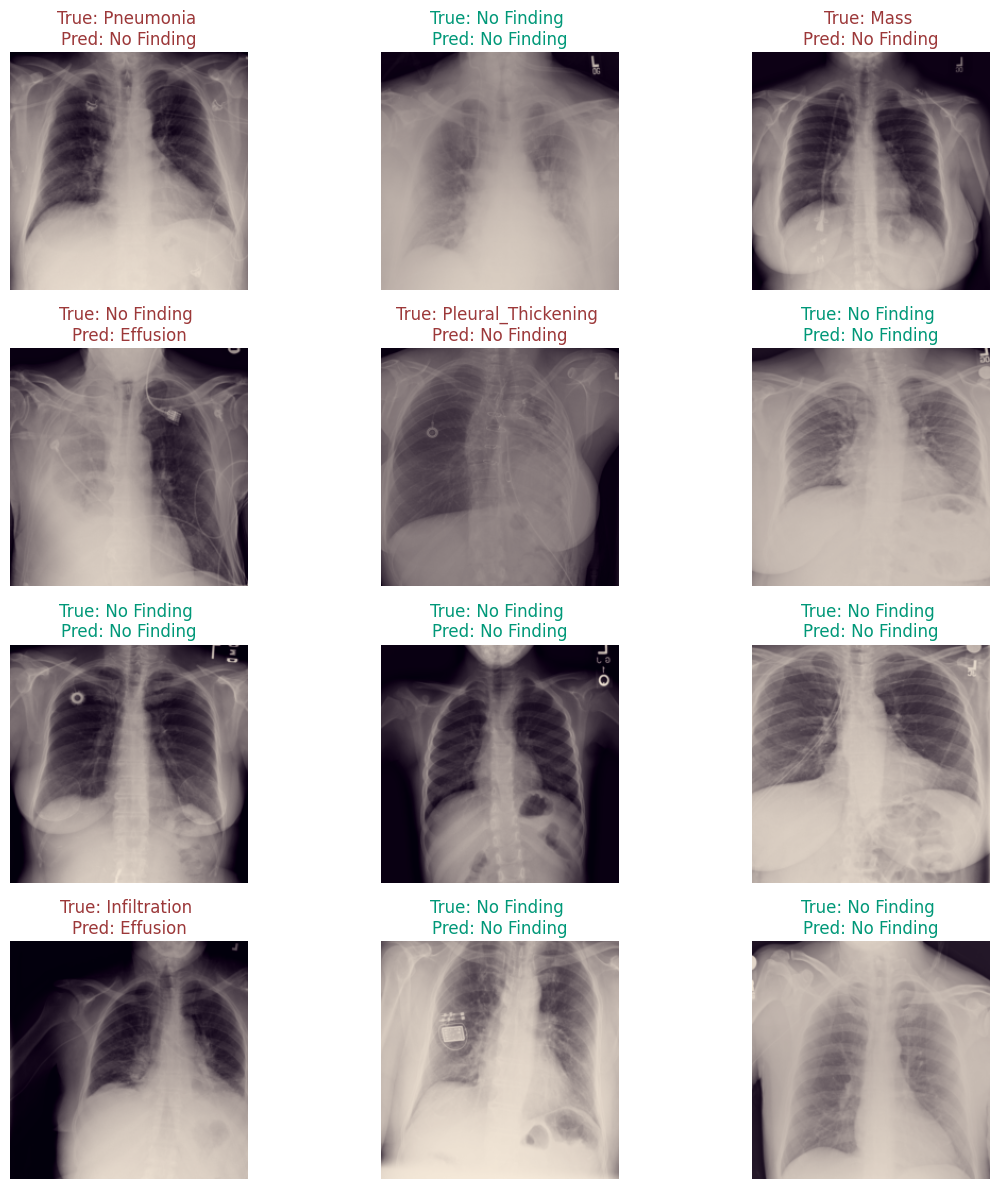

In [20]:
display_random_images(resnet50pretrained, test_dataset, test_dataset.classes)

### Confusion Matrix


In [ ]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = ComplexVGG(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

In [ ]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_pred= pred, y_true = correct)

fig,ax = plt.subplots(figsize = (15,15))
plt.title("Confusion Matrix Predicted vs Correct")

plt.imshow(conf, interpolation='none', cmap = 'YlOrRd_r')

In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/DSAN_6500/project/project_vgg.ipynb.ipynb

In [ ]:
/content/lab_8_deep_learning_image_classification_vgg-2.ipynb